In [1]:
import cupy as cp
import matplotlib.pyplot as plt

In [2]:

L_kernel = cp.RawKernel(r'''
extern "C" {    
    void __global__ L(float *data, float *f, float* R, float* cen, long n, long nz, long detw, long deth)
    {
        int tx = blockDim.x * blockIdx.x + threadIdx.x;
        int ty = blockDim.y * blockIdx.y + threadIdx.y;
        if (tx >= detw || ty >= deth)
            return;
                        
        float x = 0;
        float y = 0;
        float z = 0;
        long xr = 0;
        long yr = 0;
        long zr = 0;
        
        float data0 = 0;
        long ns = nz/R[5];///sin(phi);
        for (int t = 0; t<ns; t++)
        {
            
            x = R[0]*(tx-cen[1])+R[3]*(t-ns/2)+R[6]*(ty-cen[0]) + n/2;
            y = R[1]*(tx-cen[1])+R[4]*(t-ns/2)+R[7]*(ty-cen[0]) + n/2;
            z = R[2]*(tx-cen[1])+R[5]*(t-ns/2)+R[8]*(ty-cen[0]) + nz/2;
            xr = (long)x;
            yr = (long)y;
            zr = (long)z;
            
            // linear interp            
            if ((xr >= 0) & (xr < n - 1) & (yr >= 0) & (yr < n - 1) & (zr >= 0) & (zr < nz - 1))
            {
                x = x-xr;
                y = y-yr;
                z = z-zr;
                data0 += f[xr+yr*n+zr*n*n]*(1-x)*(1-y)*(1-z)+
                        f[xr+1+yr*n+zr*n*n]*x*(1-y)*(1-z)+
                        f[xr+(yr+1)*n+zr*n*n]*(1-x)*y*(1-z)+
                        f[xr+1+(yr+1)*n+zr*n*n]*x*y*(1-z)+
                        f[xr+yr*n+(zr+1)*n*n]*(1-x)*(1-y)*z+
                        f[xr+1+yr*n+(zr+1)*n*n]*x*(1-y)*z+
                        f[xr+(yr+1)*n+(zr+1)*n*n]*(1-x)*y*z+
                        f[xr+1+(yr+1)*n+(zr+1)*n*n]*x*y*z;
            }
        }
        data[tx + ty * detw] = data0;        
    }    
}                           
''', 'L')

# volume

(320, 512, 512)


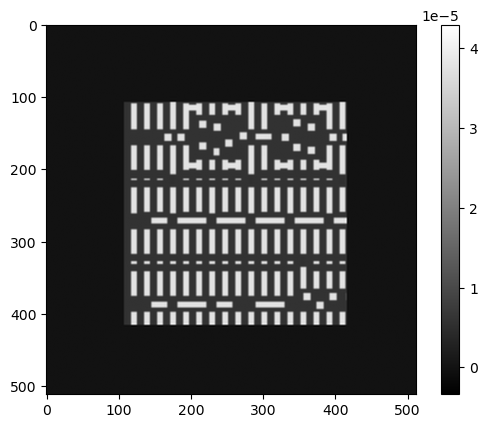

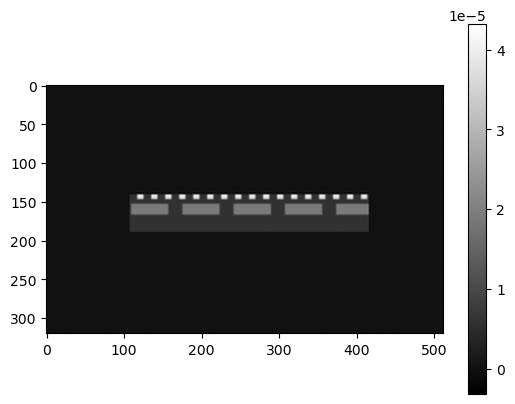

In [3]:
u = cp.load('u_real.npy')
print(u.shape)
# n = 2048
# u = cp.ones([n,n,n],dtype='float32')

plt.imshow(u[145].get(),cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(u[:,u.shape[1]//2].get(),cmap='gray')
plt.colorbar()
plt.show()

### volume and detector sizes

In [4]:
[nz,n] = u.shape[:2]
deth = nz//2 # make detector smaller
detw = n//2

### angles and rotation matrix

In [5]:
theta = cp.pi/5 # rotation
phi = 20/180*cp.pi # pitch

R = cp.zeros(9,dtype='float32')
R[0] =  cp.cos(theta);              R[1] =  cp.sin(theta);               R[2] = 0
R[3] = -cp.sin(theta)*cp.cos(phi);  R[4] =  cp.cos(theta)*cp.cos(phi);   R[5] = cp.sin(phi)
R[6] =  cp.sin(theta)*cp.sin(phi);  R[7] = -cp.cos(theta)*cp.sin(phi);   R[8] = cp.cos(phi)

### rotation axes in y and x

In [6]:
rotation_axes = cp.array([deth/2-20,detw/2+30],dtype='float32') # shifted

### Calculate laminography transform

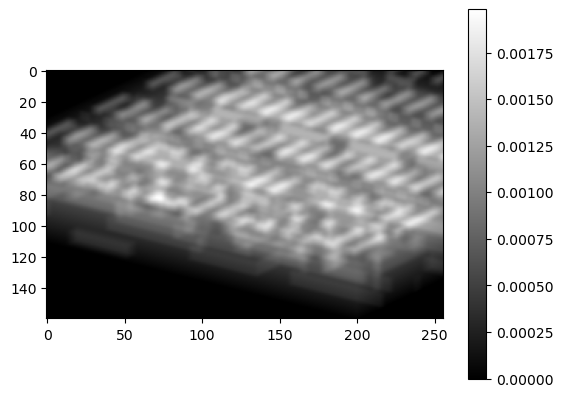

In [7]:
Lu = cp.zeros([deth,detw],dtype='float32')

L_kernel(
            (
                int(cp.ceil(detw / 32)),
                int(cp.ceil(deth / 32)),
            ),
            (32, 32),            
            (Lu, u, R, rotation_axes, n, nz, detw, deth)
        )            

plt.imshow(Lu.get(),cmap='gray')
plt.colorbar()
plt.show()